In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset

In [2]:
data = pd.read_csv('data/data.csv')
data = data.dropna()

model_data = data.drop(columns=['track_id', 'artists', 'album_name', 'track_name', 'popularity'])

model_data['explicit'] = model_data['explicit'].astype(int)

genres = model_data['track_genre'].astype('category').cat.categories
genres = {genre: i for i, genre in enumerate(genres)}
model_data['track_genre'] = model_data['track_genre'].astype('category').cat.codes

8525

In [4]:
def retrieve_color(colors):
    colors = [color.split('; ')[0] for color in colors['colors'].values[0].split('; ')]

    final_colors = []
    for color in colors:
        color = color.replace('(', '').replace(')', '').split(', ')
        color = [int(value) for value in color]
        color = np.array(color).reshape(1, 1, 3)
        final_colors.append(color)

    final_colors = np.concatenate(final_colors, axis=1)

    return final_colors

In [49]:
X = model_data.drop(columns=['colors']).values
y = model_data['colors'].values

y = [retrieve_color(data[data['colors'] == color])[0] / 255.0 for color in y]

In [51]:
class ColorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)

        y_array = np.array(y)
        self.y = torch.tensor(y_array, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

train_dataset = ColorDataset(X_train_normalized, y_train)
test_dataset = ColorDataset(X_test_normalized, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
"""
# Define the Generator network
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, output_size)  # Output size should be torch.Size([1, 30])
        )

    def forward(self, x):
        return torch.sigmoid(self.model(x))  # Apply Sigmoid activation outside the model

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
"""

In [23]:
"""
# Loss function for the Generator (Maximize Discriminator output on fake samples)
def generator_loss(fake_output):
    return -torch.mean(fake_output)

# Loss function for the Discriminator (Minimize output on real samples, Maximize output on fake samples)
def discriminator_loss(real_output, fake_output):
    return -(torch.mean(real_output) - torch.mean(fake_output))

# Initialize the Generator and Discriminator networks
input_size = 16  # Size of input features
output_size = 30  # Size of output RGB values
#generator = Generator(input_size, output_size)
discriminator = Discriminator(output_size)
# Output size representing RGB color values
generator = Generator(input_size, output_size)

# Define the optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
"""

In [17]:
"""
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, output_size),
            nn.Tanh()  # Scaled between -1 and 1 for RGB values
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_size = 16  # Adjust based on your input features
output_size = 30  # Assuming RGB color values
lr_G = 0.0002  # Learning rate for the generator
lr_D = 0.0002  # Learning rate for the discriminator
betas = (0.5, 0.999)  # Betas for Adam optimizer
num_epochs = 100
batch_size = 32

# Initialize the Generator and Discriminator networks
generator = Generator(input_size, output_size)
discriminator = Discriminator(output_size)

# Define the optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=betas)

# Loss function for the Generator
criterion = nn.BCELoss()

# Custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply the weights_init function to each layer of the model
generator.apply(weights_init)
discriminator.apply(weights_init)
"""

'\n# Training loop\nfor epoch in range(num_epochs):\n    for i, (inputs, labels) in enumerate(train_loader):\n        # Train Discriminator\n        discriminator.zero_grad()\n        real_rgb = labels.view(-1, output_size)\n        real_output = discriminator(real_rgb)\n        real_loss = criterion(real_output, torch.ones_like(real_output))\n        \n        noise = torch.randn(batch_size, input_size)\n        fake_rgb = generator(noise)\n        fake_output = discriminator(fake_rgb.detach())\n        fake_loss = criterion(fake_output, torch.zeros_like(fake_output))\n        \n        d_loss = (real_loss + fake_loss) / 2\n        d_loss.backward()\n        optimizer_D.step()\n\n        # Train Generator\n        generator.zero_grad()\n        fake_output = discriminator(fake_rgb)\n        g_loss = criterion(fake_output, torch.ones_like(fake_output))\n        g_loss.backward()\n        optimizer_G.step()\n\n        # Print losses\n        if i % 100 == 0:\n            print(f"[Epoch 

[Epoch 1/50] [Batch 1/205] Loss_D: 0.7234 Loss_G: 0.4858
[Epoch 1/50] [Batch 101/205] Loss_D: 0.6964 Loss_G: 0.5988
[Epoch 1/50] [Batch 201/205] Loss_D: 0.6934 Loss_G: 0.6318
[Epoch 2/50] [Batch 1/205] Loss_D: 0.6927 Loss_G: 0.6314
[Epoch 2/50] [Batch 101/205] Loss_D: 0.6946 Loss_G: 0.6526
[Epoch 2/50] [Batch 201/205] Loss_D: 0.6939 Loss_G: 0.6608
[Epoch 3/50] [Batch 1/205] Loss_D: 0.6913 Loss_G: 0.6613
[Epoch 3/50] [Batch 101/205] Loss_D: 0.6937 Loss_G: 0.6614
[Epoch 3/50] [Batch 201/205] Loss_D: 0.6943 Loss_G: 0.6692
[Epoch 4/50] [Batch 1/205] Loss_D: 0.6949 Loss_G: 0.6655
[Epoch 4/50] [Batch 101/205] Loss_D: 0.6930 Loss_G: 0.6703
[Epoch 4/50] [Batch 201/205] Loss_D: 0.6922 Loss_G: 0.6711
[Epoch 5/50] [Batch 1/205] Loss_D: 0.6936 Loss_G: 0.6717
[Epoch 5/50] [Batch 101/205] Loss_D: 0.6896 Loss_G: 0.6669
[Epoch 5/50] [Batch 201/205] Loss_D: 0.6897 Loss_G: 0.6761
[Epoch 6/50] [Batch 1/205] Loss_D: 0.6924 Loss_G: 0.6771
[Epoch 6/50] [Batch 101/205] Loss_D: 0.6891 Loss_G: 0.6767
[Epoch 6/

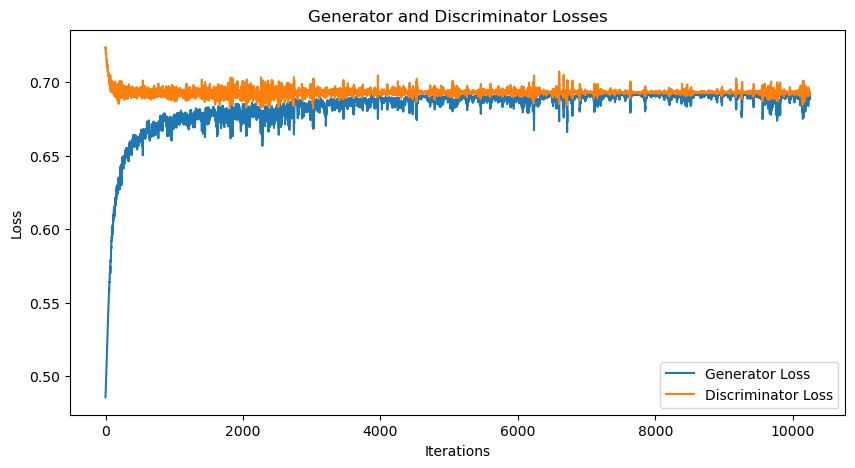

In [32]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

input_size = 16  
output_size = 30  

generator = Generator(input_size, output_size)
discriminator = Discriminator(output_size)

lr = 0.0002
beta1 = 0.5
beta2 = 0.999
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

criterion = nn.BCEWithLogitsLoss()

num_epochs = 50
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        batch_size = inputs.size(0)

        # Discriminator
        discriminator.zero_grad()
        real_rgb = labels.view(-1, output_size)
        real_output = discriminator(real_rgb)
        real_loss = criterion(real_output, torch.ones_like(real_output))
        
        noise = torch.randn(batch_size, input_size)
        fake_rgb = generator(noise)
        fake_output = discriminator(fake_rgb.detach())
        fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
        
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Generator
        generator.zero_grad()
        fake_output = discriminator(fake_rgb)
        g_loss = criterion(fake_output, torch.ones_like(fake_output))
        g_loss.backward()
        optimizer_G.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i+1}/{len(train_loader)}] "
                  f"Loss_D: {d_loss.item():.4f} Loss_G: {g_loss.item():.4f}")

plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Losses")
plt.legend()
plt.show()


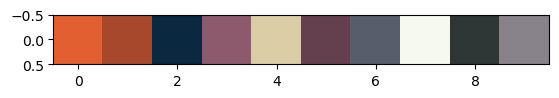

In [59]:
prueba = test_dataset[0][1]

prueba = prueba.numpy()
plt.imshow([prueba])
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated RGB values: [[-0.83130836  0.6854607  -0.8549528 ]
 [ 0.67687416  0.74556667  0.6600436 ]
 [-0.96254736 -0.84553546 -0.8580537 ]
 [-0.8969128  -0.82306284 -0.9466735 ]
 [ 0.74713874  0.03423564  0.24172926]
 [-0.85564864 -0.29930776 -0.5432379 ]
 [-0.85140353 -0.8473896  -0.89960873]
 [ 0.9369461   0.96583563  0.8483967 ]
 [-0.81833553 -0.92605615 -0.91472083]
 [-0.7254838  -0.51678705 -0.54717445]]
Actual RGB values: [[0.88235295 0.37254903 0.1882353 ]
 [0.654902   0.2784314  0.16862746]
 [0.03529412 0.15294118 0.24705882]
 [0.5529412  0.34901962 0.42352942]
 [0.85490197 0.8039216  0.6509804 ]
 [0.39215687 0.2509804  0.30588236]
 [0.34117648 0.3647059  0.41568628]
 [0.9647059  0.9764706  0.9411765 ]
 [0.1764706  0.21176471 0.20392157]
 [0.5294118  0.50980395 0.5372549 ]]


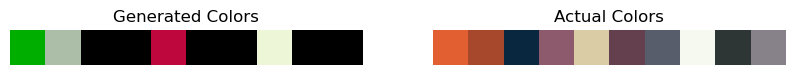

In [62]:
generator.eval()
with torch.no_grad():
    sample = test_dataset[45][0].unsqueeze(0)
    
    colors = generator(sample).squeeze().numpy()
    colors = np.clip(colors, -1, 1)

    colors = colors.reshape(10, 3)
    
    print("Generated RGB values:", colors)

    actual_colors = test_dataset[0][1].numpy()
    print("Actual RGB values:", actual_colors)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow([colors])
    ax[0].axis('off')
    ax[0].set_title("Generated Colors")
    ax[1].imshow([actual_colors])
    ax[1].axis('off')
    ax[1].set_title("Actual Colors")
    plt.show()